In [21]:
import pandas as pd
import pathpy as pp
import numpy as np
import scipy
import matplotlib.pyplot as plt


In [ ]:
def load_df():
    network_df = pd.read_excel (r'manufacturing_emails_temporal_network.xlsx')
    return network_df

def load_df_as_network(df):
    temporal = pp.TemporalNetwork()
    for ind in df.index:
        temporal.add_edge(df['node1'][ind], df['node2'][ind], int(df['timestamp'][ind]))
    return temporal

net_df = load_df()
temporal = load_df_as_network(net_df)

net_df


In [ ]:
links = net_df[["node1","node2"]]
links = links.drop_duplicates()
net = pp.Network(directed=False)
np_links = links.to_numpy()
for l in np_links:
    net.add_edge(l[0]-1, l[1]-1)
print(net)


In [ ]:
pp.algorithms.modularity.assortativity_coeff(net)
# assortativity_coeff(net)
A = net.adjacency_matrix()
print(A)

scipy.sparse.linalg.eigs(A)

In [ ]:

gdata = net_df.copy()
print(gdata)

g2 = gdata.copy()
g2['timestamp'] = np.random.permutation(g2.timestamp)
print(g2)



In [ ]:

print(links)
g3 = pd.DataFrame()

timestamps = gdata['timestamp'].to_numpy()
node1s = links['node1'].to_numpy()
node2s = links['node2'].to_numpy()

nodes = np.stack((node1s, node2s), axis=1)

n1 = []
n2 = []
ts = []

for t in timestamps:
    tuple = nodes[np.random.randint(nodes.shape[0], size=1), :][0]
    n1.append(tuple[0])
    n2.append(tuple[1])
    ts.append(t)

g3['node1'] = np.array(n1)
g3['node2'] = np.array(n2)
g3['timestamp'] = np.array(ts)
g3.columns = ['node1', 'node2', 'timestamp']
print(g3)


In [19]:
# Ordering dataframes by node1, node2 and then timestamp
gdata = gdata.sort_values(by=['node1', 'node2', 'timestamp'])
print(gdata)
g2 = g2.sort_values(by=['node1', 'node2', 'timestamp'])
g3 = g3.sort_values(by=['node1', 'node2', 'timestamp'])

      node1  node2  timestamp
0         1      2          1
377       1      2        254
378       1      2        255
589       1      2        414
1026      1      2        718
...     ...    ...        ...
7315    146    147       4910
7445    146    147       4999
7481    146    147       5024
7721    146    147       5193
8510    146    147       5747

[82876 rows x 3 columns]


In [17]:
def get_time_intervals(df):
    node1s = df['node1'].to_numpy()
    node2s = df['node2'].to_numpy()
    times = df['timestamp'].to_numpy()
    assert(len(node1s) == len(node2s) == len(times))

    intervals = []
    for t in range(len(times)-1):
        if (node1s[t] == node1s[t+1] and node2s[t] == node2s[t+1]):
            intervals.append(times[t+1]-times[t])
        else: 
            continue
    return intervals

55284
55966
25077


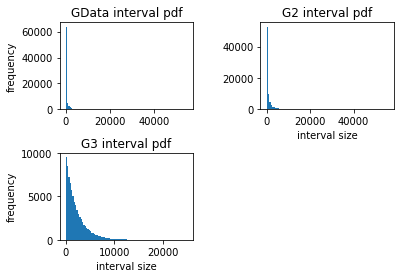

In [106]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.5, wspace=0.5)

fig = plt.figure()

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
gdata_intervals = get_time_intervals(gdata)
print(max(gdata_intervals))
_, bins, _ = ax1.hist(gdata_intervals, bins=90)
ax1.set_title('GData interval pdf')
ax1.set_ylabel('frequency')

ax2 = fig.add_subplot(gs[0, 1])
g2_intervals = get_time_intervals(g2)
print(max(g2_intervals))
_, bins, _ = ax2.hist(g2_intervals, bins=90)
ax2.set_title('G2 interval pdf')
ax2.set_xlabel('interval size')

ax3 = fig.add_subplot(gs[1, 0])
g3_intervals = get_time_intervals(g3)
print(max(g3_intervals))
_, bins, _ = ax3.hist(g3_intervals, bins=90)
ax3.set_title('G3 interval pdf')
ax3.set_xlabel('interval size')
ax3.set_ylabel('frequency')
# print(bins)
# gdata_intervals = get_time_intervals(g3)
# print(max(gdata_intervals))
# plt.hist(get_time_intervals(gdata), bins=50)
# plt.yscale('log')
plt.savefig('q14.png')
